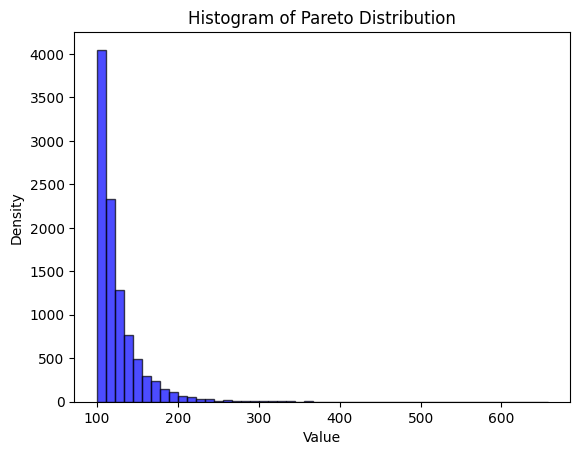

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def pareto(alpha, m, size=1000):
    """Generate random samples from a Pareto distribution."""
    u = np.random.rand(size)
    samples = m / np.power(u, 1.0/alpha)
    return samples

# Parameters for Pareto distribution
alpha = 5  # Shape parameter
m = 100.0  # Scale parameter

# Generate Pareto distributed samples
samples = pareto(alpha, m, size=10000)

# Plotting the histogram
plt.hist(samples, bins=50, density=False, alpha=0.7, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram of Pareto Distribution')

# Show plot
plt.show()


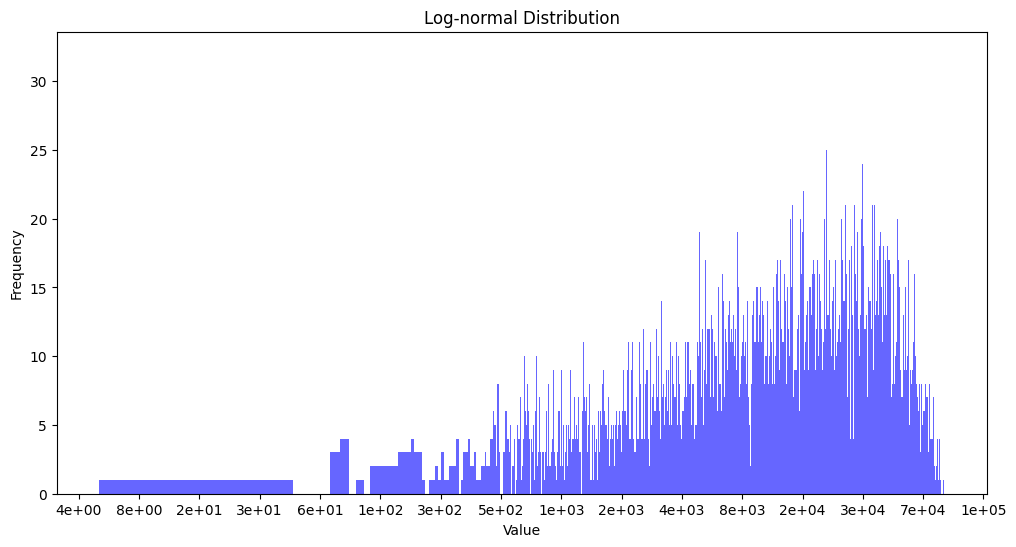

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FormatStrFormatter

# 设置随机种子以确保可重复性
np.random.seed(42)

# 生成对数正态分布的数据
mu = 3     # 对数正态分布的均值（对数刻度）
sigma = 1  # 对数正态分布的标准差（对数刻度）
# s = np.random.lognormal(mu, sigma, 1000)
alpha, beta = 1.5, 2
s = np.random.beta(alpha, beta, 100000) * 168 * 500


# 绘制统计直方图
plt.figure(figsize=(12, 6))
count, bins, ignored = plt.hist(s, bins=10000, density=False, alpha=0.6, color='b')

# # 为了对比，在同一图上绘制对数正态分布的概率密度函数（PDF）
# x = np.linspace(min(s), max(s), 10000)
# pdf = (np.exp(-(np.log(x) - mu) ** 2 / (2 * sigma ** 2))
#        / (x * sigma * np.sqrt(2 * np.pi)))
# plt.plot(x, pdf, linewidth=2, color='r')

# # 设置对数刻度
plt.xscale('log')
ax = plt.gca()
ax.xaxis.set_major_locator(LogLocator(base=2.0, numticks=100))
ax.xaxis.set_minor_locator(LogLocator(base=2.0, subs='auto', numticks=100))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.e'))

# 设置图表标题和标签
plt.title('Log-normal Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


In [115]:
ss = [sss*12 for sss in s if sss>=500]
count, bins, ignored = plt.hist(ss, bins=5000, density=False, alpha=0.6, color='b')
plt.xscale('log')

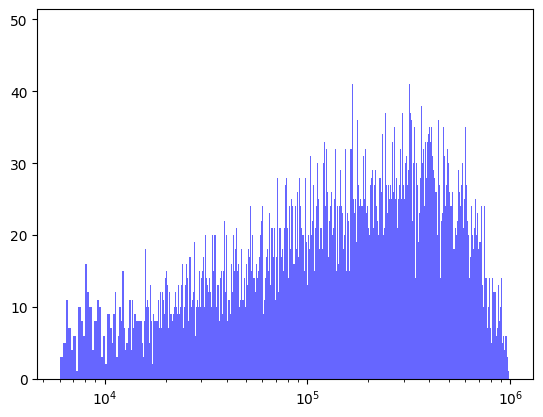

In [116]:
count, bins, ignored = plt.hist(ss, bins=5000, density=False, alpha=0.6, color='b')
plt.xscale('log')

In [1]:
from utils import beta_dist

[1.0848554  1.0766936  1.30679079 1.04433821 1.00552396 1.03578304
 2.21900343 1.13360808 1.06479214 3.3329926 ]


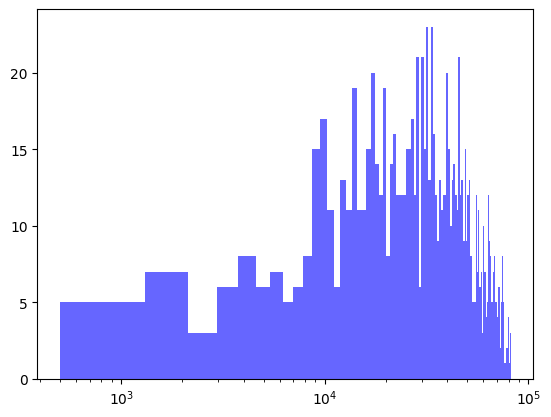

In [11]:
s = []
for i in range(1000):
    s.append(beta_dist()[0])
count, bins, ignored = plt.hist(s, bins=100, density=False, alpha=0.6, color='b')
plt.xscale('log')

In [10]:
s

[20226.371522458063,
 44867.452603393496,
 19165.284875130747,
 36423.80489213292,
 23250.09538128126,
 78135.3954349898,
 44497.208303228945,
 2330.8920511479355,
 32127.581309989666,
 6097.845649019048,
 73992.04348844638,
 12168.205382311839,
 73681.31119211092,
 44792.12229083287,
 14608.007943432884,
 37630.83290284745,
 29560.287340038394,
 61831.95497173131,
 56172.37353548314,
 37039.93760203084,
 54575.04015401151,
 35697.402783800644,
 3769.016045733274,
 62551.41256460925,
 76076.70556686375,
 18938.270222618317,
 53332.5492585845,
 69637.35651764595,
 26188.342756397593,
 59866.549297178404,
 25490.637977458242,
 40370.70499711239,
 23284.004604417692,
 68414.60319127001,
 17752.349712744315,
 12575.101526434206,
 33511.086156221114,
 30553.44323547449,
 18801.971671751893,
 8460.081794539215,
 16746.903424142387,
 67079.05246264998,
 32428.611986634052,
 24405.526270667586,
 2096.3173662479917,
 16206.488363468654,
 68459.83567489318,
 13104.437773221573,
 27217.0896236091